In [18]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr

In [19]:
def polynomial(x,y):
    return (-44.27677739 + (x*(115.67737032)) + (y*(-24.5631504)) + ((x*y)*(93.56679366)) + ((x**2)*(-108.01788098)) + ((y**2)*(-118.19369438)) + ((x**2)*y*(-78.89488701)) + ((y**2)*x*(150.57376231)) + ((x**3)*(37.64771891)) + ((y**3)*(-65.50782695)))


In [20]:
polynomial(1,2)

-413.29440051999995

In [21]:

data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [22]:
u_des = objs['DECAM_U']
g_des = objs['DES_G']
r_des = objs['DES_R']
i_des = objs['DES_I']
z_des = objs['DES_Z']
feh_des = objs['FEH']
u_g_des = u_des - g_des
g_r_des = g_des - r_des


In [23]:
u_g_des = u_g_des + .3

In [24]:
#apply shift found in isochrone_minimize_residuals_01OCT2019
u_g_des = u_g_des - .005
g_r_des = g_r_des - .005

In [25]:
#reduce area to around selection box
selected = np.where((u_g_des>=0.4)&(u_g_des<=1.3)&(g_r_des>=0)&(g_r_des<=0.4))
u_g_des = u_g_des[selected]
g_r_des = g_r_des[selected]
feh_des = feh_des[selected]

In [26]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [27]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [28]:
ret = {}
xedge = {}
yedge = {}
bin = {}

In [29]:
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [30]:
ret['iso_image'],xedge['iso_image'],yedge['iso_image'],bin['iso_image'] = stats.binned_statistic_2d(u_g_des,g_r_des,feh_des,'median',50)    


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


[Text(1,0,'−2.0'),
 Text(1,0,'−1.5'),
 Text(1,0,'−1.0'),
 Text(1,0,'−0.5'),
 Text(1,0,'0.0')]

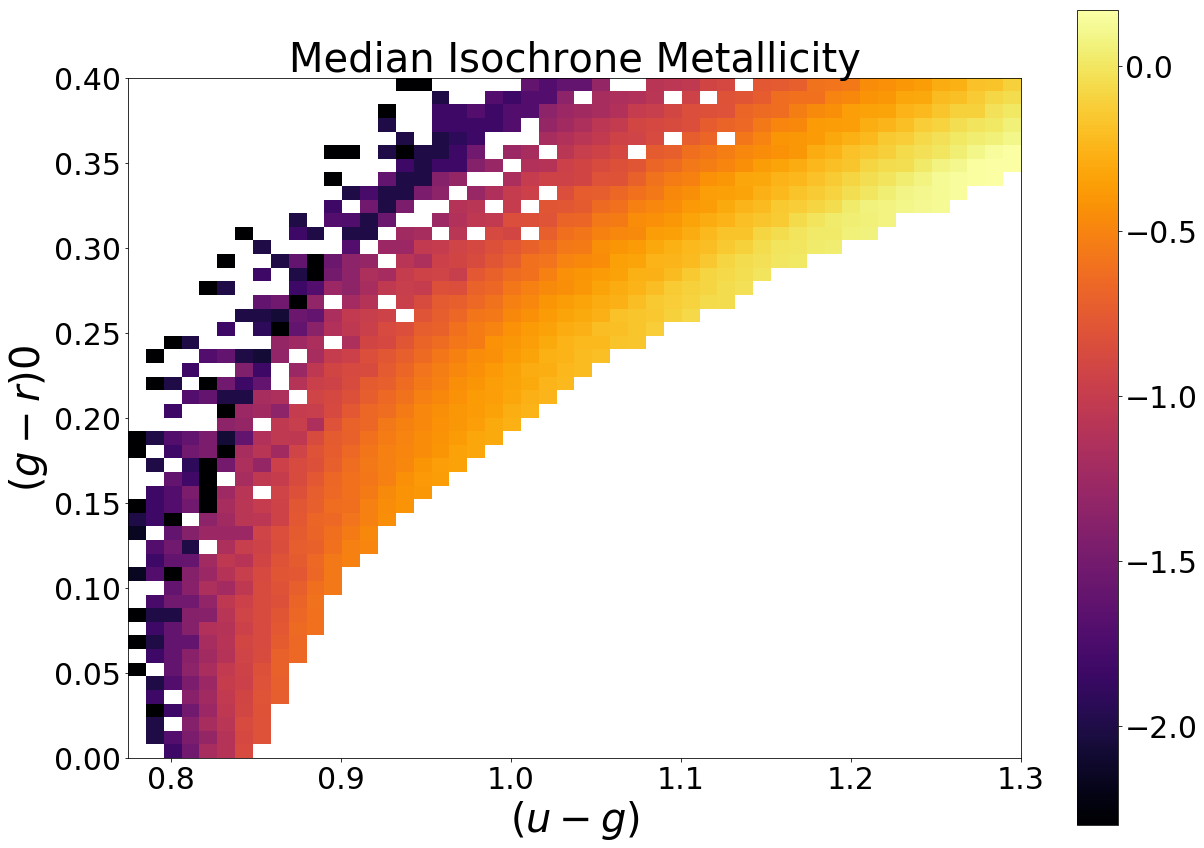

In [31]:

fig, ax = plt.subplots(figsize=(20,15))
im = ax.imshow(ret['iso_image'].T,origin='lower',extent=[xedge['iso_image'].min(),xedge['iso_image'].max(),yedge['iso_image'].min(),yedge['iso_image'].max()],cmap='inferno')
ax.set_title('PARSEC Isochrone Data',fontsize=15)
ax.set_xlabel('$(u-g)$',fontsize=40)
ax.set_ylabel('$(g-r)0$',fontsize=40)
ax.set_title('Median Isochrone Metallicity',fontsize=40)

ax.tick_params(axis='both', which='major', labelsize=30)
cb=fig.colorbar(im,ax=ax)
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=30)



In [32]:
xedge['iso_image'][2] - xedge['iso_image'][1]

0.010499995946884222

In [33]:
yedge['iso_image'][2] - yedge['iso_image'][1]

0.007999997828155756

# x bin: 0.0104 y 0.01

In [34]:
fields= [1,   2,   3,   4,   5,   7,   8,   9,  12,  13,  14,  15,  16,
        18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  31,  32,  33,
        34,  37,  40,  44,  46,  49,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  63,  64,  66,  68, 149, 150, 156, 176, 177,
       178]

In [35]:
metal = {}
std = {}
error = {}
initial_stars = []
cut_stars = []
for i, method in enumerate (('original','iso_image','iso_poly')):
    metal[method] = []
    std[method] = []
    error[method] = []


In [36]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    cut_stars.append(len(u))
    stars = len(u)
    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh_og = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh_og))
    print("number of stars calculated for og method ",N)
    #mean_metallicity['original'].append(np.nanmean(feh))
    print("metallicity for original method:",(np.nanmedian(feh_og)))
    metal['original'].append(np.nanmedian(feh_og))
    std['original'].append(np.nanstd(feh_og))
    error['original'].append((np.nanstd(feh_og))/np.sqrt(N))

    #isochrone metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['iso_image'].min())&((u_g)<=xedge['iso_image'].max())&((g_r)>=yedge['iso_image'].min())&((g_r)<=yedge['iso_image'].max()))
    ix = np.searchsorted(xedge['iso_image'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['iso_image'],(g_r)[ind])
    iy = iy - 1
    feh = ret['iso_image'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    print("number of stars for iso image method ",N)
    #mean_metallicity['original'].append(np.nanmean(feh))
    print("metallicity for iso image method:",(np.nanmedian(feh)))
    metal['iso_image'].append(np.nanmedian(feh))
    std['iso_image'].append(np.nanstd(feh))
    error['iso_image'].append((np.nanstd(feh))/np.sqrt(N))
    
    selected = np.where((u_g>=0.4)&(u_g<=1.3)&(g_r>=0)&(g_r<=0.4))
    u_g = u_g[selected]
    g_r = g_r[selected]
    
    feh = polynomial(u_g,g_r)
    #print("length of polynomial feh ",len(feh))
    metal['iso_poly'].append(np.nanmedian(feh))
    N = np.count_nonzero(~np.isnan(feh))
    print("number of stars in iso poly method: ",N)
    print("metallicity for iso poly method:",(np.nanmedian(feh)))
    #print(feh_method['poly'])
    std['iso_poly'].append(np.nanstd(feh))
    error['iso_poly'].append((np.nanstd(feh))/np.sqrt(N))
    metal['iso_poly'].append(np.nanmedian(feh))
    std['iso_poly'].append(np.nanstd(feh))
    error['iso_poly'].append((np.nanstd(feh))/np.sqrt(N))
        
    

    return 0


In [37]:

if __name__=="__main__":
    for number in fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

number of initial stars in field 1: 46634
number of stars after cuts in field 1: 2849
number of stars calculated for og method  250
metallicity for original method: -1.199785590171814
number of stars for iso image method  148
metallicity for iso image method: -0.8619076609611511
number of stars in iso poly method:  916
metallicity for iso poly method: -4.2753296
number of initial stars in field 2: 61991
number of stars after cuts in field 2: 3435
number of stars calculated for og method  1663
metallicity for original method: -1.3767668008804321
number of stars for iso image method  1115
metallicity for iso image method: -0.8860567808151245
number of stars in iso poly method:  3299
metallicity for iso poly method: -2.02054
number of initial stars in field 3: 847797
number of stars after cuts in field 3: 65489
number of stars calculated for og method  46244
metallicity for original method: -1.3419320583343506
number of stars for iso image method  33933
metallicity for iso image method: -

number of initial stars in field 31: 46943
number of stars after cuts in field 31: 1132
number of stars calculated for og method  384
metallicity for original method: -1.5431206226348877
number of stars for iso image method  243
metallicity for iso image method: -1.0000001192092896
number of stars in iso poly method:  984
metallicity for iso poly method: -3.935643
number of initial stars in field 32: 1825281
number of stars after cuts in field 32: 152476
number of stars calculated for og method  98533
metallicity for original method: -1.274411916732788
number of stars for iso image method  69438
metallicity for iso image method: -0.7958799600601196
number of stars in iso poly method:  147977
metallicity for iso poly method: -1.2411492
number of initial stars in field 33: 45996
number of stars after cuts in field 33: 1105
number of stars calculated for og method  219
metallicity for original method: -1.3419320583343506
number of stars for iso image method  134
metallicity for iso image 

number of initial stars in field 68: 90704
number of stars after cuts in field 68: 689
number of stars calculated for og method  498
metallicity for original method: -1.4411659240722656
number of stars for iso image method  290
metallicity for iso image method: -0.9167490601539612
number of stars in iso poly method:  604
metallicity for iso poly method: -1.7333598
number of initial stars in field 149: 69283
number of stars after cuts in field 149: 616
number of stars calculated for og method  397
metallicity for original method: -1.5431206226348877
number of stars for iso image method  276
metallicity for iso image method: -1.0786766409873962
number of stars in iso poly method:  588
metallicity for iso poly method: -1.7204944
number of initial stars in field 150: 46060
number of stars after cuts in field 150: 343
number of stars calculated for og method  201
metallicity for original method: -1.572399616241455
number of stars for iso image method  118
metallicity for iso image method: -

In [38]:
lmc = [32,34,37,40,46,49,51,156,24,26,27,28,29,31,33,44,52,53,54,55,56,57,58,59,60,61,63,64,66,68]
smc = [12,14,15,16,19,2,3,4,5,7,9,1,13,149,150,176,177,178,18,20,21,22,8]

In [39]:
old = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]


In [40]:
#ra and dec of each SMASH field and of the centers of LMC/SMC: WARNING: correspond to old fields array!!!!!!!!!!!!!
ra = np.array([2.58282, 4.74128, 5.8295, 6.23604, 11.0282, 11.2637, 12.6438, 15.3642, 17.2959, 19.3929, 20.1116, 21.1397, 22.3556, 32.3014, 33.2987, 33.7735, 38.0154, 40.8729, 48.7252, 55.0714, 62.0399, 62.2076, 71.5224, 72.8794, 73.2326, 73.826, 74.3797, 74.8251, 75.6417, 78.0543, 79.5644, 81.6974, 83.023, 84.5087, 85.416, 87.2541, 87.3605, 89.5211, 96.3535, 96.7494, 98.0372, 98.2317, 107.298, 108.637, 111.26, 111.286, 114.087, 114.673, 118.049, 120.112, 128.154, 130.919, 351.667, 351.815, 115.38663, 10.65102, 22.45883, 25.12044, 101.835])
dec = np.array([-69.7946, -77.0834, -73.9689, -72.3856, -71.6294, -74.8041, -82.474, -70.7182, -75.4505, -78.5112, -71.2591, -72.825, -74.3674, -73.2717, -77.5124, -67.4354, -70.2838, -74.5334, -72.4893, -76.4147, -72.0384, -68.4171, -75.3739, -68.7777, -80.7479, -70.5799, -84.3086, -72.3767, -67.5258, -66.2141, -72.8687, -66.6022, -76.3886, -73.2367, -66.8939, -71.7809, -68.5956, -70.2803, -79.9982, -67.1805, -75.1855, -70.3668, -68.3137, -54.6223, -59.3505, -64.5201, -76.1913, -70.9916, -67.0089, -84.4426, -72.6595, -76.0996, -72.0863, -67.6899, -54.888583, -67.7937, -67.39283, -71.2175, -52.264999])
#associated SkyCoord object
c_fields = SkyCoord(ra,dec,unit='deg')

#LMC center
ra_lmc = 81.900000
dec_lmc = -69.866667
#SMC center
ra_smc = 13.183333
dec_smc = -72.828333
#associated SkyCoord objects
c_lmc = SkyCoord(ra_lmc,dec_lmc,unit='deg')
c_smc = SkyCoord(ra_smc,dec_smc,unit='deg')

#calculate radii from LMC/SMC center
radii_lmc = c_fields.separation(c_lmc).degree
radii_smc = c_fields.separation(c_smc).degree

#calculate position angle to LMC/SMC center
pa_lmc = c_fields.position_angle(c_lmc).degree
pa_smc = c_fields.position_angle(c_smc).degree

In [41]:
lmc_index_old = []
for i in np.arange(0,len(old)):
    for j in lmc:
        if old[i]==j:
            lmc_index_old.append(i)

In [42]:
lmc_index = []
for i in np.arange(0,len(fields)):
    for j in lmc:
        if fields[i]==j:
            lmc_index.append(i)

In [43]:
smc_index = []
for i in np.arange(0,len(fields)):
    for j in smc:
        if fields[i]==j:
            smc_index.append(i)

In [44]:
smc_index_old = []
for i in np.arange(0,len(old)):
    for j in smc:
        if old[i]==j:
            smc_index_old.append(i)

In [45]:
metal['offset'] = [i+0.6 for i in metal['original']]

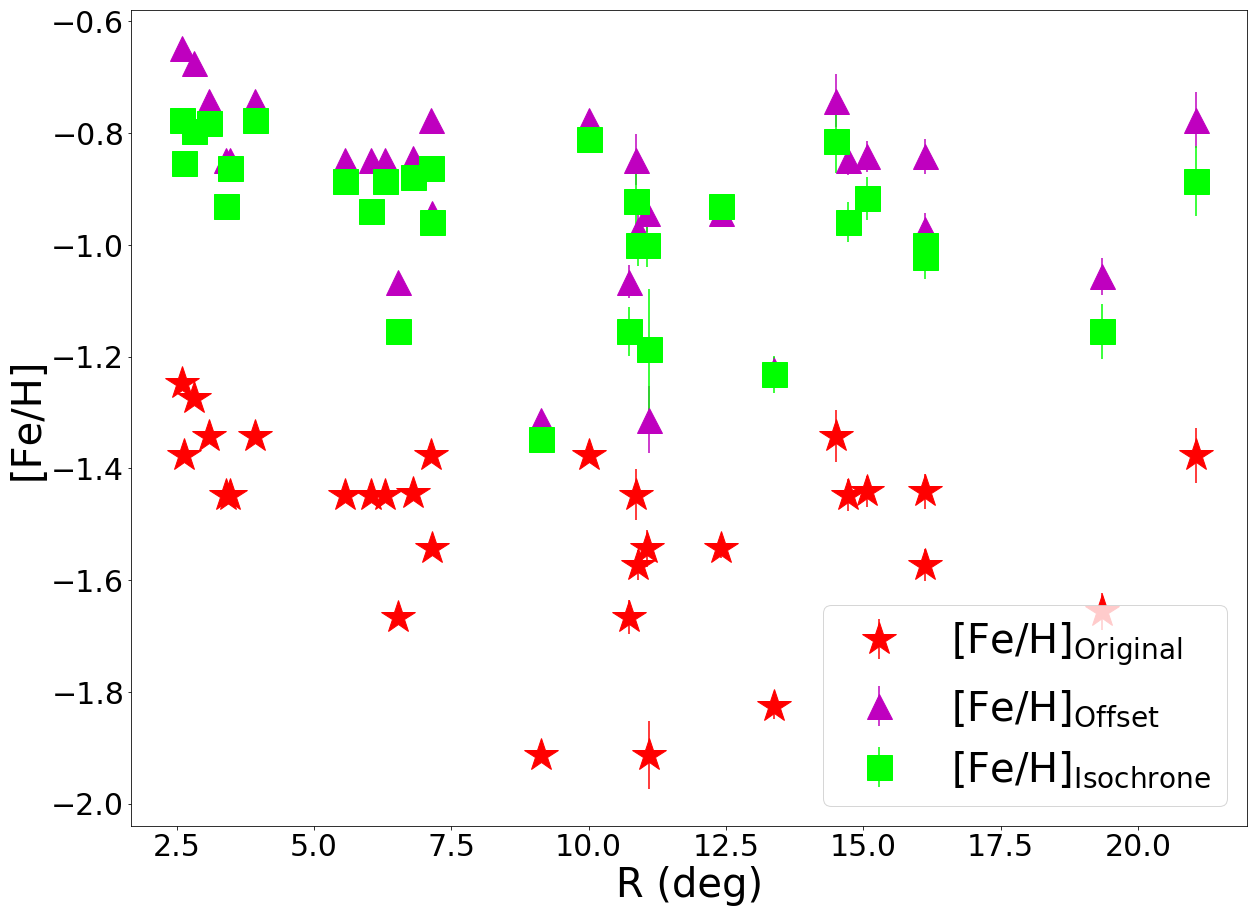

In [46]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','b','g','c','m']

ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['original'])[lmc_index],yerr=np.array(error['original'])[lmc_index],fmt='*',c='r',markersize=35,label='[Fe/H]$_{\mathregular{Original}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['offset'])[lmc_index],yerr=np.array(error['original'])[lmc_index],fmt='^',c=colors[5],markersize=25,label='[Fe/H]$_{\mathregular{{Offset}}}$')
ax.errorbar(radii_lmc[lmc_index_old],np.array(metal['iso_image'])[lmc_index],yerr=np.array(error['iso_image'])[lmc_index],fmt='s',c='lime',markersize=25,label='[Fe/H]$_{\mathregular{Isochrone}}$')


plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        

ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)
    

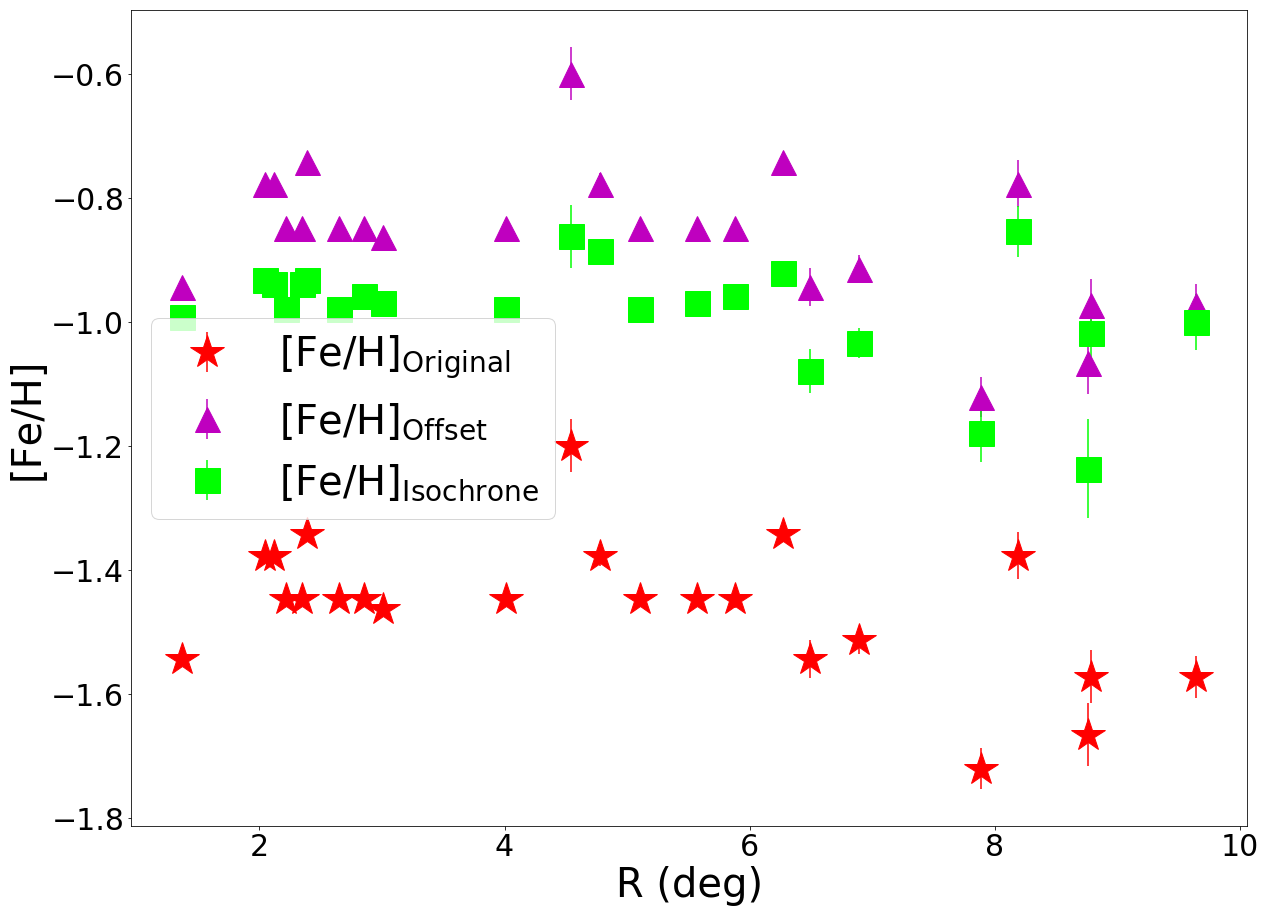

In [49]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['y','k','b','g','c','m']

ax.errorbar(radii_smc[smc_index_old],np.array(metal['original'])[smc_index],yerr=np.array(error['original'])[smc_index],fmt='*',c='r',markersize=35,label='[Fe/H]$_{\mathregular{Original}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['offset'])[smc_index],yerr=np.array(error['original'])[smc_index],fmt='^',c=colors[5],markersize=25,label='[Fe/H]$_{\mathregular{{Offset}}}$')
ax.errorbar(radii_smc[smc_index_old],np.array(metal['iso_image'])[smc_index],yerr=np.array(error['iso_image'])[smc_index],fmt='s',c='lime',markersize=25,label='[Fe/H]$_{\mathregular{Isochrone}}$')
plt.xlabel('R (deg)',fontsize=23)
plt.ylabel('[Fe/H]',fontsize=23)
        
plt.xlabel('R (deg)',fontsize=40)
plt.ylabel('[Fe/H]',fontsize=40)
        
ax.tick_params(axis='both', which='major', labelsize=30)
#ax.set_ylim(-2.2,-.6)
ax.legend(fontsize=40)
    

In [34]:
diff = np.array(metal['iso_image']) - np.array(metal['original'])

In [35]:
np.mean(diff)

0.5139874309863685

### Right now, best method is using the cut PARSEC isochrone data to make a binned image w/ 50 bins, polynomial method looks like crap

#### Next, look at residuals of isochrone image

In [36]:
ind, = np.where(((u_g_des)>=xedge['iso_image'].min())&((u_g_des)<=xedge['iso_image'].max())&((g_r_des)>=yedge['iso_image'].min())&((g_r_des)<=yedge['iso_image'].max()))
ix = np.searchsorted(xedge['iso_image'],(u_g_des)[ind])
ix = ix - 1
iy = np.searchsorted(yedge['iso_image'],(g_r_des)[ind])
iy = iy - 1
feh = ret['iso_image'][ix,iy]
N = np.count_nonzero(~np.isnan(feh))
print("number of stars for iso image method ",N)
#mean_metallicity['original'].append(np.nanmean(feh))
print("metallicity for iso image method:",(np.nanmedian(feh)))



number of stars for iso image method  9614
metallicity for iso image method: -0.22184884548187256


In [37]:
x = np.arange(-4,1,.001)

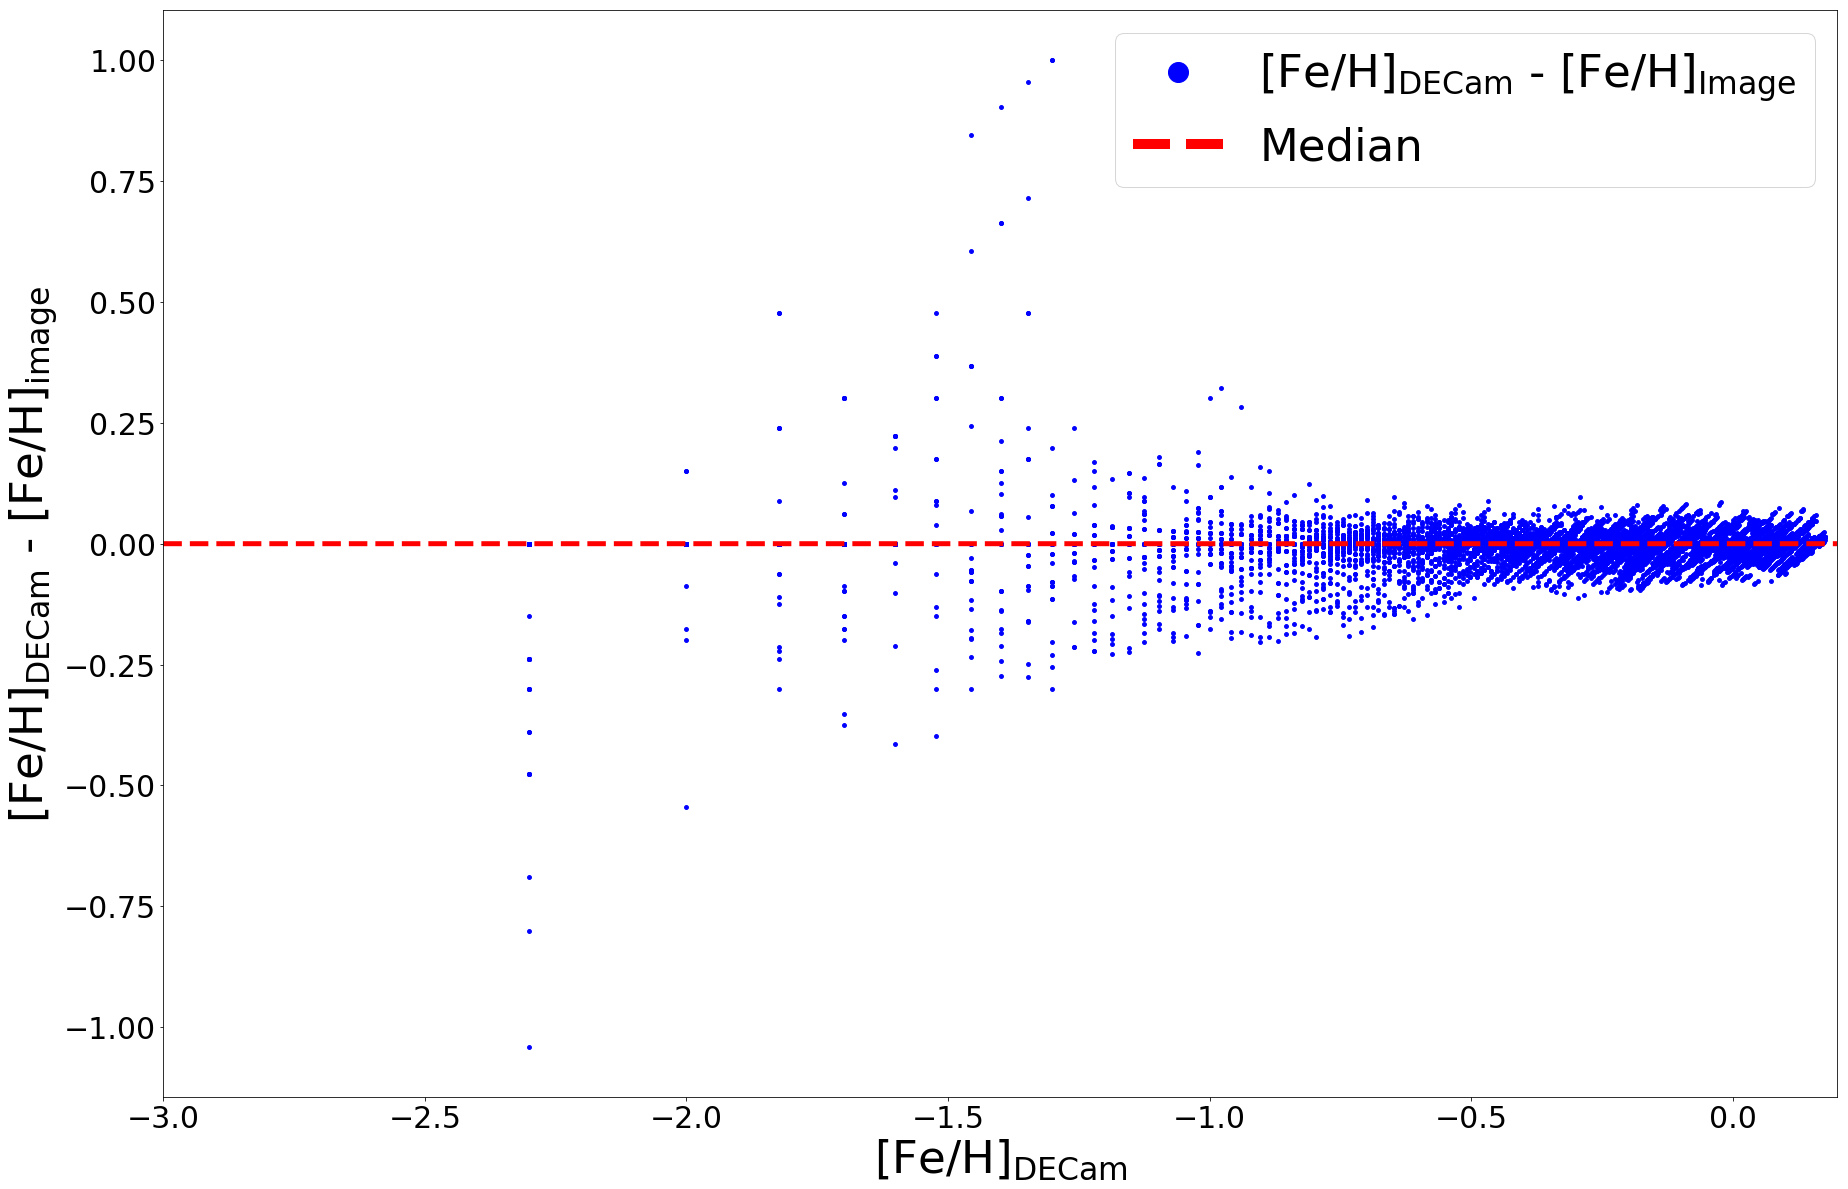

In [73]:
blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{Image}$')
red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

delta = feh_des - feh

fig, ax = plt.subplots(figsize=(30,20))

ax.scatter(feh_des,delta,c='b',s=15)
plt.xlabel('[Fe/H]$_\mathregular{DECam}$',fontsize=45)
plt.ylabel('[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{image}$',fontsize=45)
plt.plot(x,(np.nanmedian(delta)*np.ones(5000)),'--',c='r',linewidth=5,label='Median')
ax.set_xlim(-3,.2)
        
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(handles=[blue,red],fontsize=45)


In [74]:
np.nanmean(delta)

-0.004733037199675479

In [75]:
np.nanmedian(delta)

0.0

In [76]:
index = np.arange(-2.5,0,1)

In [77]:
index

array([-2.5, -1.5, -0.5])

In [78]:
#Can you estimate the RMS error (root mean squared) of the residuals?  
#This will be the systematic error.  
#If you can do them in bins of ~1 dex of metallicity that might also be useful 
#(probably higher at the metal-poor end).

rms = []
for i in index:
    if i == -2.5:
        selected = np.where((feh_des >= -2.5)& (feh_des <= -1.5))
    else:
        selected = np.where((feh_des > i)& (feh_des <= (i+1)))
    feh1 = feh_des[selected]
    feh2 = feh[selected]
    delta2 = feh1 - feh2
    #print(delta2)
    array = []
    for j in delta2:
        array.append(j**2)
    rms.append((np.sqrt(np.nanmean(array))))
    #print(np.sqrt(array))



In [79]:
rms

[0.15818536900833285, 0.08162152422687328, 0.027462558782303186]

In [80]:
xvalues = [-2,-1,0]

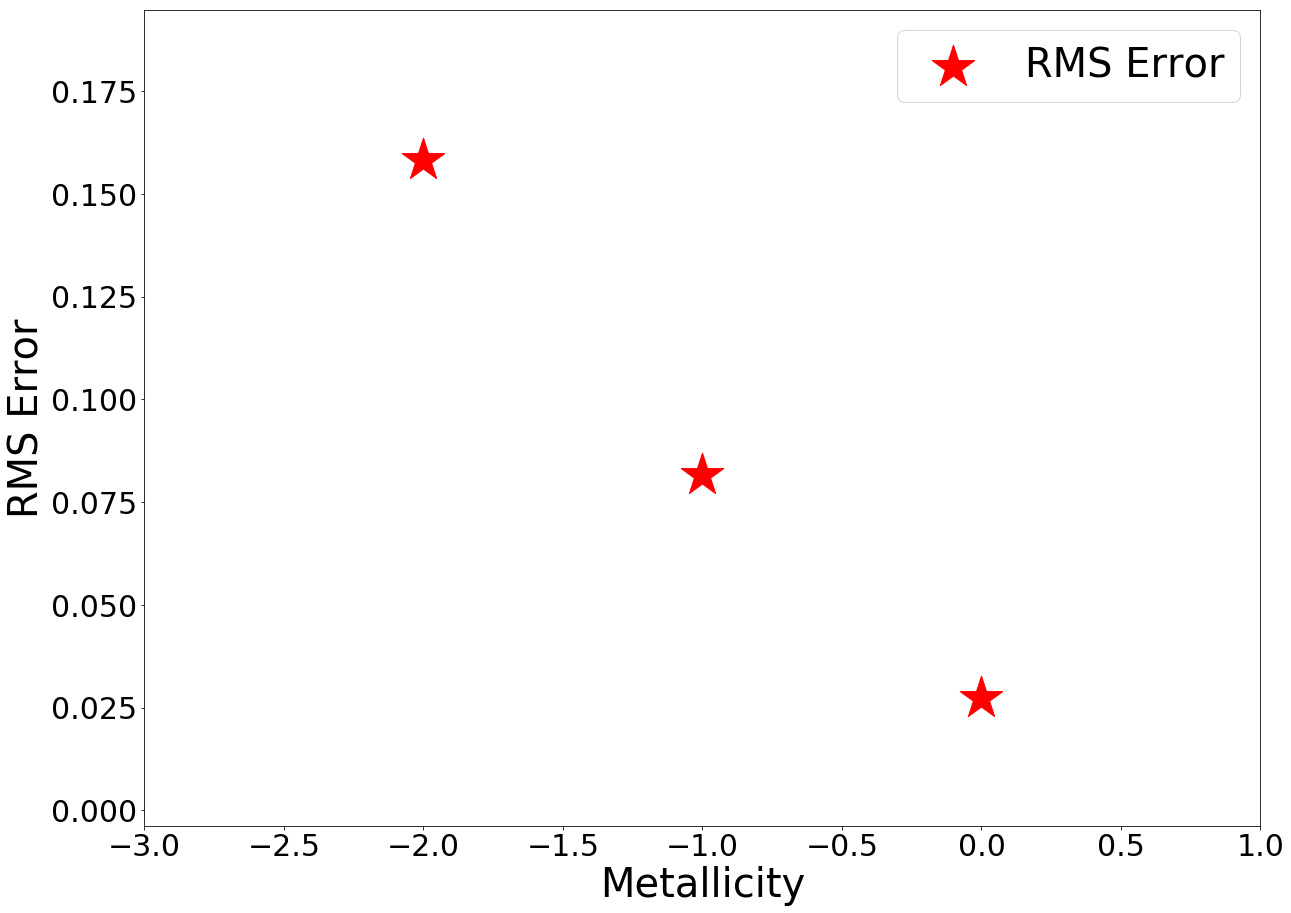

In [81]:
#x axis: [Fe/H]_spec
#y axis: delta [Fe/H]: my values - spectroscopic value: straight line
#the shape tells us about how our my method is doing
#blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='Residuals')
#red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

#pink = mlines.Line2D([], [], color='hotpink', marker='s',linestyle='None',markersize=30, label='RMS Error')

fig, ax = plt.subplots(figsize=(20,15))

#ax.bar(xvalues,rms,width=1,color='hotpink',edgecolor='navy',linewidth=5,label='RMS Error')
#ax.errorbar(xvalues,y,yerr=rms,fmt='*',c='r',markersize=35,elinewidth=7)
ax.scatter(xvalues,rms,marker='*',c='r',s=2000,label='RMS Error')
plt.xlabel('Metallicity',fontsize=40)
plt.ylabel('RMS Error',fontsize=40)
ax.set_xlim(-3,1)
ax.legend(fontsize=40)
#ax.set_xticks(np.arange(-2.5,1.5,1))
ax.tick_params(axis='both', which='major', labelsize=30)



#### Now, run calibration sample through isochrone image method

In [82]:
#reduce area to around selection box
selected, = np.where((u_g_cal>=0.4)&(u_g_cal<=1.3)&(g_r_cal>=0)&(g_r_cal<=0.4))
u_g_cal = u_g_cal[selected]
g_r_cal = g_r_cal[selected]
feh_cal = feh_cal[selected]

In [83]:
len(feh_cal)

939

In [84]:
ind, = np.where(((u_g_cal)>=xedge['iso_image'].min())&((u_g_cal)<=xedge['iso_image'].max())&((g_r_cal)>=yedge['iso_image'].min())&((g_r_cal)<=yedge['iso_image'].max()))
ix = np.searchsorted(xedge['iso_image'],(u_g_cal)[ind])
ix = ix - 1
iy = np.searchsorted(yedge['iso_image'],(g_r_cal)[ind])
iy = iy - 1
feh = ret['iso_image'][ix,iy]
N = np.count_nonzero(~np.isnan(feh))
print("number of stars for iso image method ",N)
#mean_metallicity['original'].append(np.nanmean(feh))
print("metallicity for iso image method:",(np.nanmedian(feh)))



number of stars for iso image method  719
metallicity for iso image method: -0.9393020868301392


In [85]:
u_g_cal = u_g_cal[ind]
g_r_cal = g_r_cal[ind]
feh_cal = feh_cal[ind]

In [86]:
len(feh_cal)

939

In [87]:
len(feh)

939

In [88]:
feh.shape

(939,)

In [89]:
feh_cal.shape

(939,)

In [90]:
selected = np.where(feh != np.nan)

In [91]:
feh_cal = feh_cal[selected]
feh = feh[selected]

In [92]:
x = np.arange(-4,1,.001)

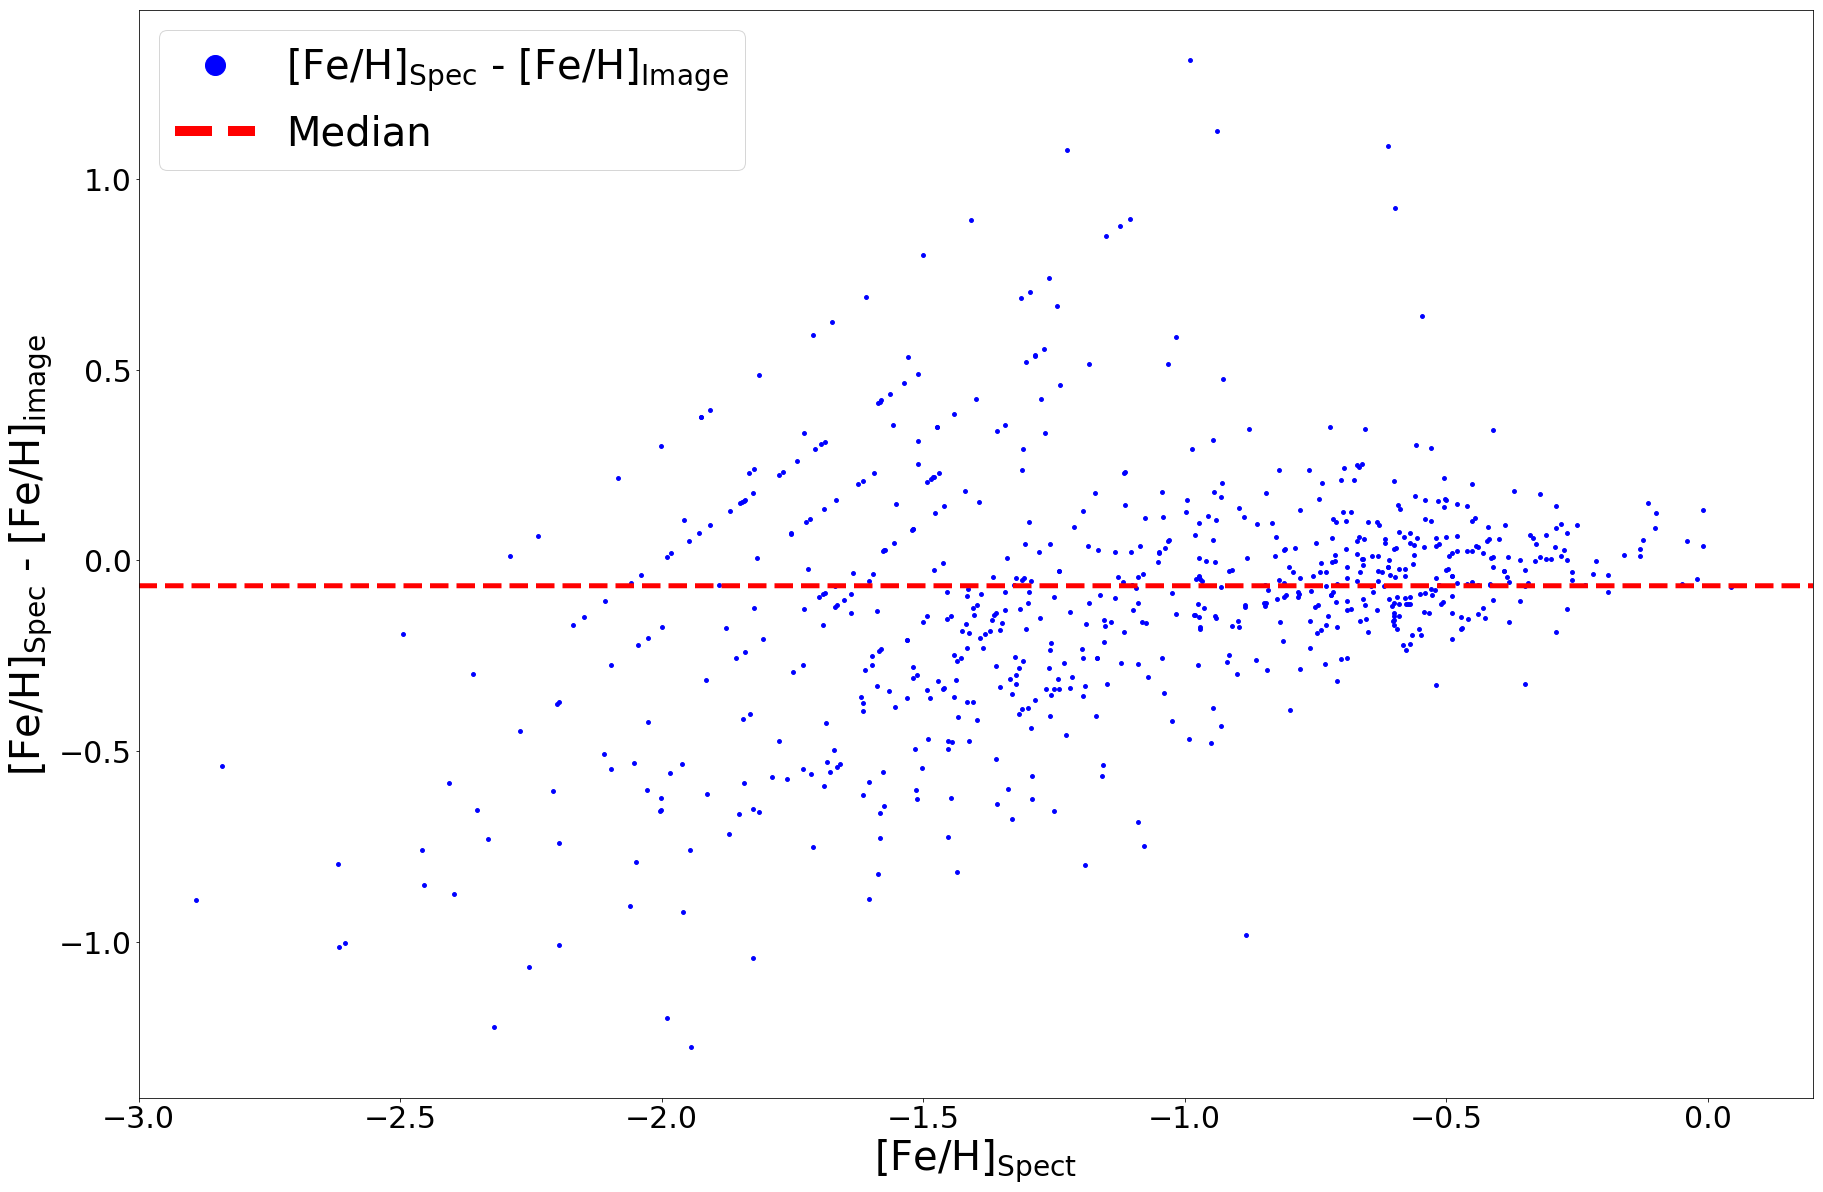

In [93]:
blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{Spec}$ - [Fe/H]$_\mathregular{Image}$')
red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

delta = feh_cal - feh

fig, ax = plt.subplots(figsize=(30,20))

ax.scatter(feh_cal,delta,c='b',s=15)
plt.xlabel('[Fe/H]$_\mathregular{Spect}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{Spec}$ - [Fe/H]$_\mathregular{image}$',fontsize=40)
plt.plot(x,(np.nanmedian(delta)*np.ones(5000)),'--',c='r',linewidth=5,label='Median')
ax.set_xlim(-3,.2)
        
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(handles=[blue,red],fontsize=40)


In [94]:
np.nanmedian(delta)

-0.06632030010223389

#### Calculate RMS error of the residuals

In [95]:
index = np.arange(-3.0,0,1)

In [96]:
index

array([-3., -2., -1.])

In [97]:
#Can you estimate the RMS error (root mean squared) of the residuals?  
#This will be the systematic error.  
#If you can do them in bins of ~1 dex of metallicity that might also be useful 
#(probably higher at the metal-poor end).

rms = []
for i in index:
    if i == -3:
        selected = np.where((feh_cal >= -3)& (feh_cal <= -2))
    else:
        selected = np.where((feh_cal > i)& (feh_cal <= (i+1)))
        print(i)
        print(i+1)
    feh_cal1 = feh_cal[selected]
    feh2 = feh[selected]
    delta2 = feh_cal1 - feh2
    #print(delta2)
    array = []
    for j in delta2:
        array.append(j**2)
    rms.append((np.sqrt(np.nanmean(array))))
    #print(np.sqrt(array))



-2.0
-1.0
-1.0
0.0


In [98]:
rms

[0.6237137603826264, 0.3868076804944857, 0.19790919717910468]

In [99]:
xvalues = [-2.5, -1.5, -0.5]

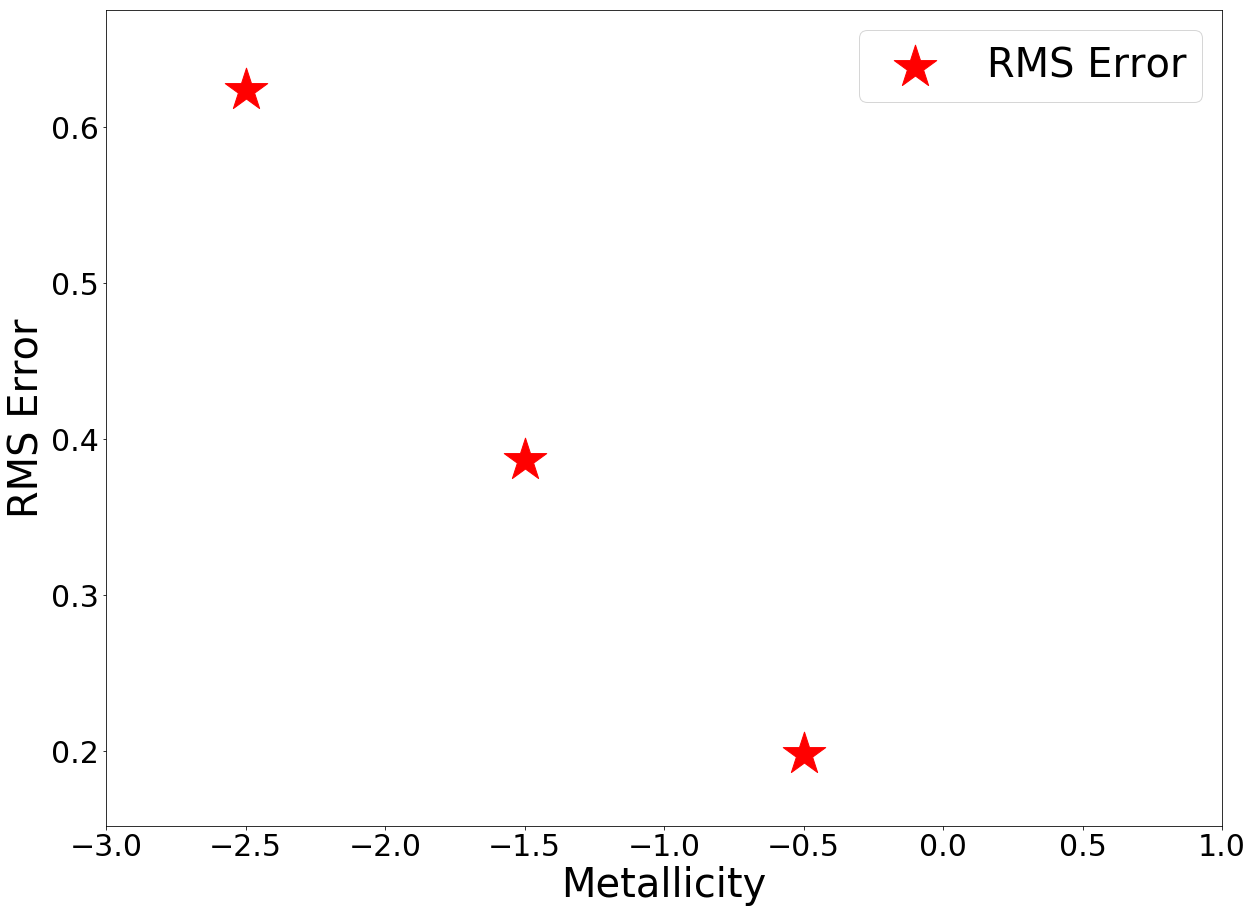

In [100]:
#x axis: [Fe/H]_spec
#y axis: delta [Fe/H]: my values - spectroscopic value: straight line
#the shape tells us about how our my method is doing
#blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='Residuals')
#red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

#pink = mlines.Line2D([], [], color='hotpink', marker='s',linestyle='None',markersize=30, label='RMS Error')

fig, ax = plt.subplots(figsize=(20,15))

#ax.bar(xvalues,rms,width=1,color='hotpink',edgecolor='navy',linewidth=5,label='RMS Error')
#ax.errorbar(xvalues,y,yerr=rms,fmt='*',c='r',markersize=35,elinewidth=7)
ax.scatter(xvalues,rms,marker='*',c='r',s=2000,label='RMS Error')
plt.xlabel('Metallicity',fontsize=40)
plt.ylabel('RMS Error',fontsize=40)
ax.set_xlim(-3,1)
ax.legend(fontsize=40)
#ax.set_xticks(np.arange(-2.5,1.5,1))
ax.tick_params(axis='both', which='major', labelsize=30)

